# T2* map calculation tutorial

Start by importing the required libraries and defining some settings:

In [1]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import warnings

from ukat.data import fetch
from ukat.mapping.t2star import T2Star

# Ensure figures are rendered in the notebook
%matplotlib inline

# Hide T2Star_Nottingham() RuntimeWarnings
warnings.filterwarnings('ignore')

Tell python where to store the T2* maps NIfTI files we will generate. We will store it in a directory called `t2star_calculation_output` in the `tutorials` directory.

In [2]:
# Initialise output path for T2star map
OUTPUT_DIR = os.path.join(os.getcwd(), "t2star_calculation_output")
OUTPUT_PATH_PHILIPS = os.path.join(OUTPUT_DIR, 'T2StarMapPHILIPS.nii.gz')
OUTPUT_PATH_GE = os.path.join(OUTPUT_DIR, 'T2StarMapGE.nii.gz')
OUTPUT_PATH_SIEMENS = os.path.join(OUTPUT_DIR, 'T2StarMapSIEMENS.nii.gz')

Retrieve T2* test data using our data fetcher.
This will return 3 variables:
* `image`: a 4D array with the magnitude data at all echo times.
* `affine`: the affine matrix for the data (needed to later write a new NIfTI file).
* `TEs`: an array containing the echo times, in seconds.

In [3]:
# Fetch test data
image_philips, affine_philips, TE_philips = fetch.r2star_philips()
image_ge, affine_ge, TE_ge = fetch.r2star_ge()
image_siemens, affine_siemens, TE_siemens = fetch.r2star_siemens()

Compute the T2* maps using the `T2Star` class implemented in `methods`:

In [4]:
# Compute the 3 manufacturers T2star maps - this can take around 1 minute
TE_philips = TE_philips*1000  # convert TEs to ms
t2star_philips = T2Star(image_philips, TE_philips).t2star_nottingham()[0]
TE_ge = TE_ge*1000  # convert TEs to ms
t2star_ge = T2Star(image_ge, TE_ge).t2star_nottingham()[0]
TE_siemens = TE_siemens*1000  # convert TEs to ms
t2star_siemens = T2Star(image_siemens, TE_siemens).t2star_nottingham()[0]

Display a central slice of the T2* maps. Note the units are _ms_.

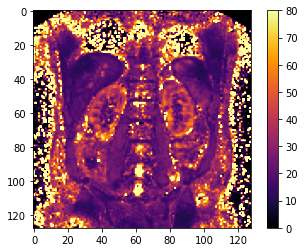

In [5]:
# Display a central slice of the T2star map Philips
t2star_central_slice = np.rot90(t2star_philips[:,:,2], 1)
ax = plt.subplots()[1]
im = ax.imshow(t2star_central_slice, cmap='inferno', vmin=0, vmax=80)
plt.colorbar(im)
plt.show()

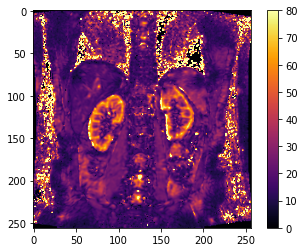

In [6]:
# Display a central slice of the T2star map GE
t2star_central_slice = np.rot90(t2star_ge[:,:,2], 1)
ax = plt.subplots()[1]
im = ax.imshow(t2star_central_slice, cmap='inferno', vmin=0, vmax=80)
plt.colorbar(im)
plt.show()

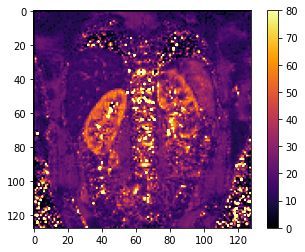

In [7]:
# Display a central slice of the T2star map Siemens
t2star_central_slice = np.rot90(t2star_siemens[:,:,2], 1)
ax = plt.subplots()[1]
im = ax.imshow(t2star_central_slice, cmap='inferno', vmin=0, vmax=80)
plt.colorbar(im)
plt.show()

Save the resulting T2* maps as a NIfTI files:

In [8]:
# Save results to new NifTI files
t2star_nifti_object_philips = nib.Nifti1Image(t2star_philips, affine=affine_philips)
nib.save(t2star_nifti_object_philips, OUTPUT_PATH_PHILIPS)
t2star_nifti_object_ge = nib.Nifti1Image(t2star_ge, affine=affine_ge)
nib.save(t2star_nifti_object_ge, OUTPUT_PATH_GE)
t2star_nifti_object_siemens = nib.Nifti1Image(t2star_siemens, affine=affine_siemens)
nib.save(t2star_nifti_object_siemens, OUTPUT_PATH_SIEMENS)